In [ ]:
bd# Get the trained weights of the InceptionV3 model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-11-23 14:13:52--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   180MB/s    in 0.5s    

2021-11-23 14:13:53 (180 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd


In [ ]:
path_inception = f"{getcwd()}/../tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the InceptionV3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the InceptionV3 model. Don't include top since we need to add own CNN
pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None
)

# Load the weigths into the pre-trained model
local_weights_file = path_inception
pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model untrainable
for layer in pre_trained_model.layers:
  layer.trainable = False

# pre_trained_model.summary()

In [ ]:
# The shape of the last layer
last_layer = pre_trained_model.get_layer('mixed10')
print(f"Last layer output shape: {last_layer.output_shape}")

# Get the output of the last layer
last_output = last_layer.output

Last layer output shape: (None, 3, 3, 2048)


In [ ]:
# Define a callback to stop training when we've reached an accuracy of 97%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('acc') > 0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output from the last layer
x = layers.Flatten()(last_output)
# Dense layer
x = layers.Dense(1024, activation='relu')(x)
# Dropout layer where 20% of the dense layer nodes will be dropped
x = layers.Dropout(0.2)(x)
# Output layer with 1 node since it's a binary classifier
x = layers.Dense(1, activation='sigmoid')(x)

# Create a connected model from the two definitions
model = Model(pre_trained_model.input, x)
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['acc']
)
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

# Prepare the ImageGenerators

In [ ]:
!gdown --id 1onaG42NZft3wCE1WH0GDEbUhu75fedP5
!gdown --id 1LYeusSEIiZQpwN-mthh5nKdA75VsKG1U

Downloading...
From: https://drive.google.com/uc?id=1onaG42NZft3wCE1WH0GDEbUhu75fedP5
To: /content/horse-or-human.zip
100% 150M/150M [00:01<00:00, 140MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LYeusSEIiZQpwN-mthh5nKdA75VsKG1U
To: /content/validation-horse-or-human.zip
100% 11.5M/11.5M [00:00<00:00, 113MB/s]


In [ ]:
import os
import zipfile

# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

local_zip = "./horse-or-human.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(train_dir)

local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(validation_dir)

zip_ref.close()

In [ ]:
train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    target_size=(150, 150),
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size=20,
    target_size=(150, 150),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
callbacks = [myCallback()]
history = model.fit(
  train_generator,
  epochs=10,
  steps_per_epoch=50,
  verbose=2,
  callbacks=callbacks,
  validation_data=validation_generator,
  validation_steps=12
)

Epoch 1/10

Reached 97.0% accuracy so cancelling training!
50/50 - 13s - loss: 0.1321 - acc: 0.9757 - val_loss: 3.6646e-04 - val_acc: 1.0000 - 13s/epoch - 259ms/step


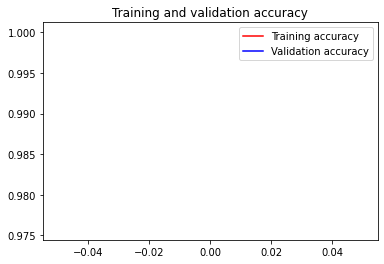

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()